In [90]:
import networkx as nx
import matplotlib.pyplot as plt

## QAOA Maxcut Solver 
Maxcut problem requires less qubits to solve than QAP's n^2

In [91]:
%%capture
import networkx as nx

In [92]:
def G(n, seed, probability, sparse=True, w=None, r=True):
    """
    Generates a seeded random graph with n nodes. 
    probability between 0 and 1 to increase odds.
    sparse means if we want a sparse or dense graph.
    w is the weight of the edges if wanted.
    r means if we want random weights or not.
    """
    random.seed(seed)
    G = nx.Graph()
    G.add_nodes_from(range(n))
    for i, j in itertools.combinations(G.nodes, 2):
        if sparse == True:
            if random.random() > (1 - probability):
                if r == True:
                    G.add_edge(i, j, weight=random.random())
                else:
                    G.add_edge(i, j, weight=w)
        if sparse == False:
            #Means we want a dense network, so
            if r == True:
                G.add_edge(i, j, weight=random.random())
            else:
                G.add_edge(i, j, weight=w)
    return G

In [93]:
import random
import itertools
GG = G(10, 1, 0.5, sparse=True, w=1, r=False)
adjacency = nx.adjacency_matrix(GG).todense()

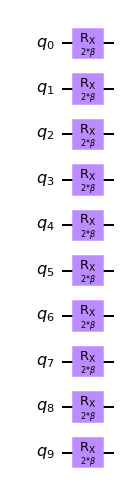

In [94]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter

# Adjacency is essentially a matrix which tells you which nodes are
# connected. This matrix is given as a sparse matrix, so we need to
# convert it to a dense matrix
G = GG 
adjacency = nx.adjacency_matrix(G).todense()
nqubits = 10

beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_mix.rx(2 * beta, i)
    
qc_mix.draw(output='mpl')


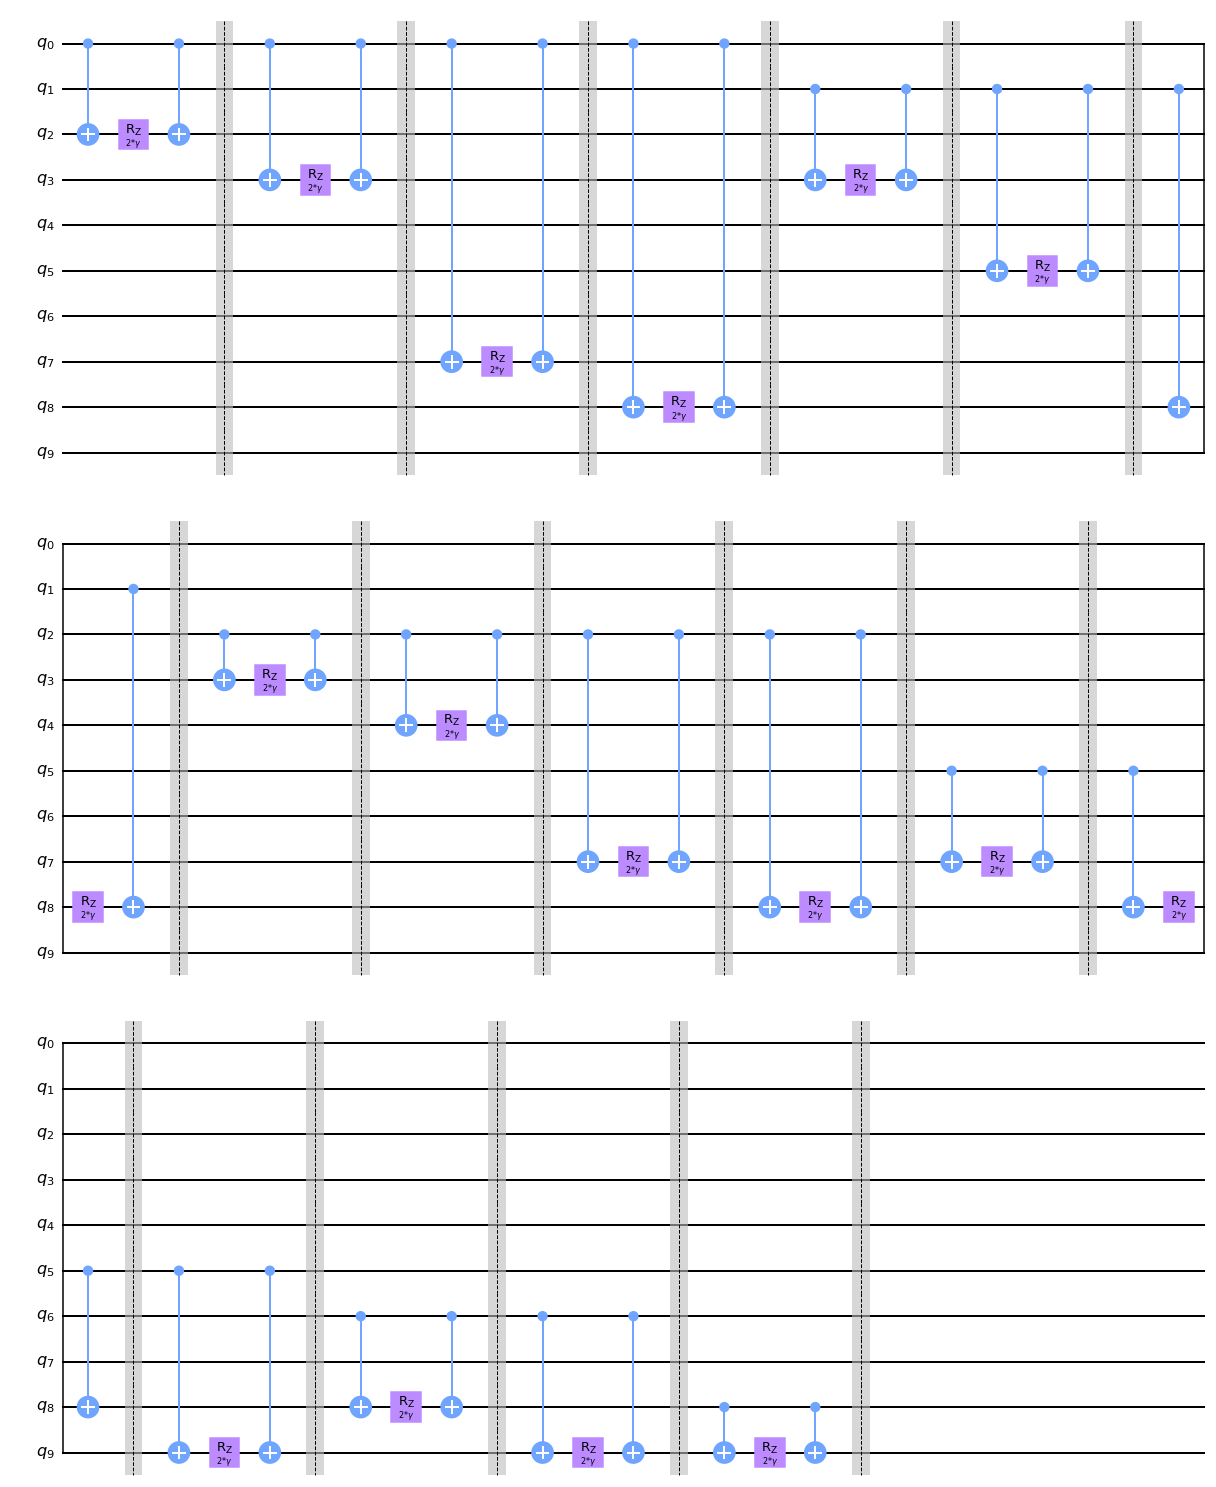

In [95]:
gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(nqubits)
for pair in list(G.edges()):  # pairs of nodes
    qc_p.rzz(2 * gamma, pair[0], pair[1])
    qc_p.barrier()
    
qc_p.decompose().draw(output='mpl')


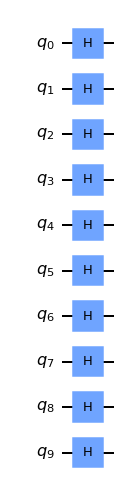

In [96]:
qc_0 = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_0.h(i)
    
qc_0.draw(output='mpl')


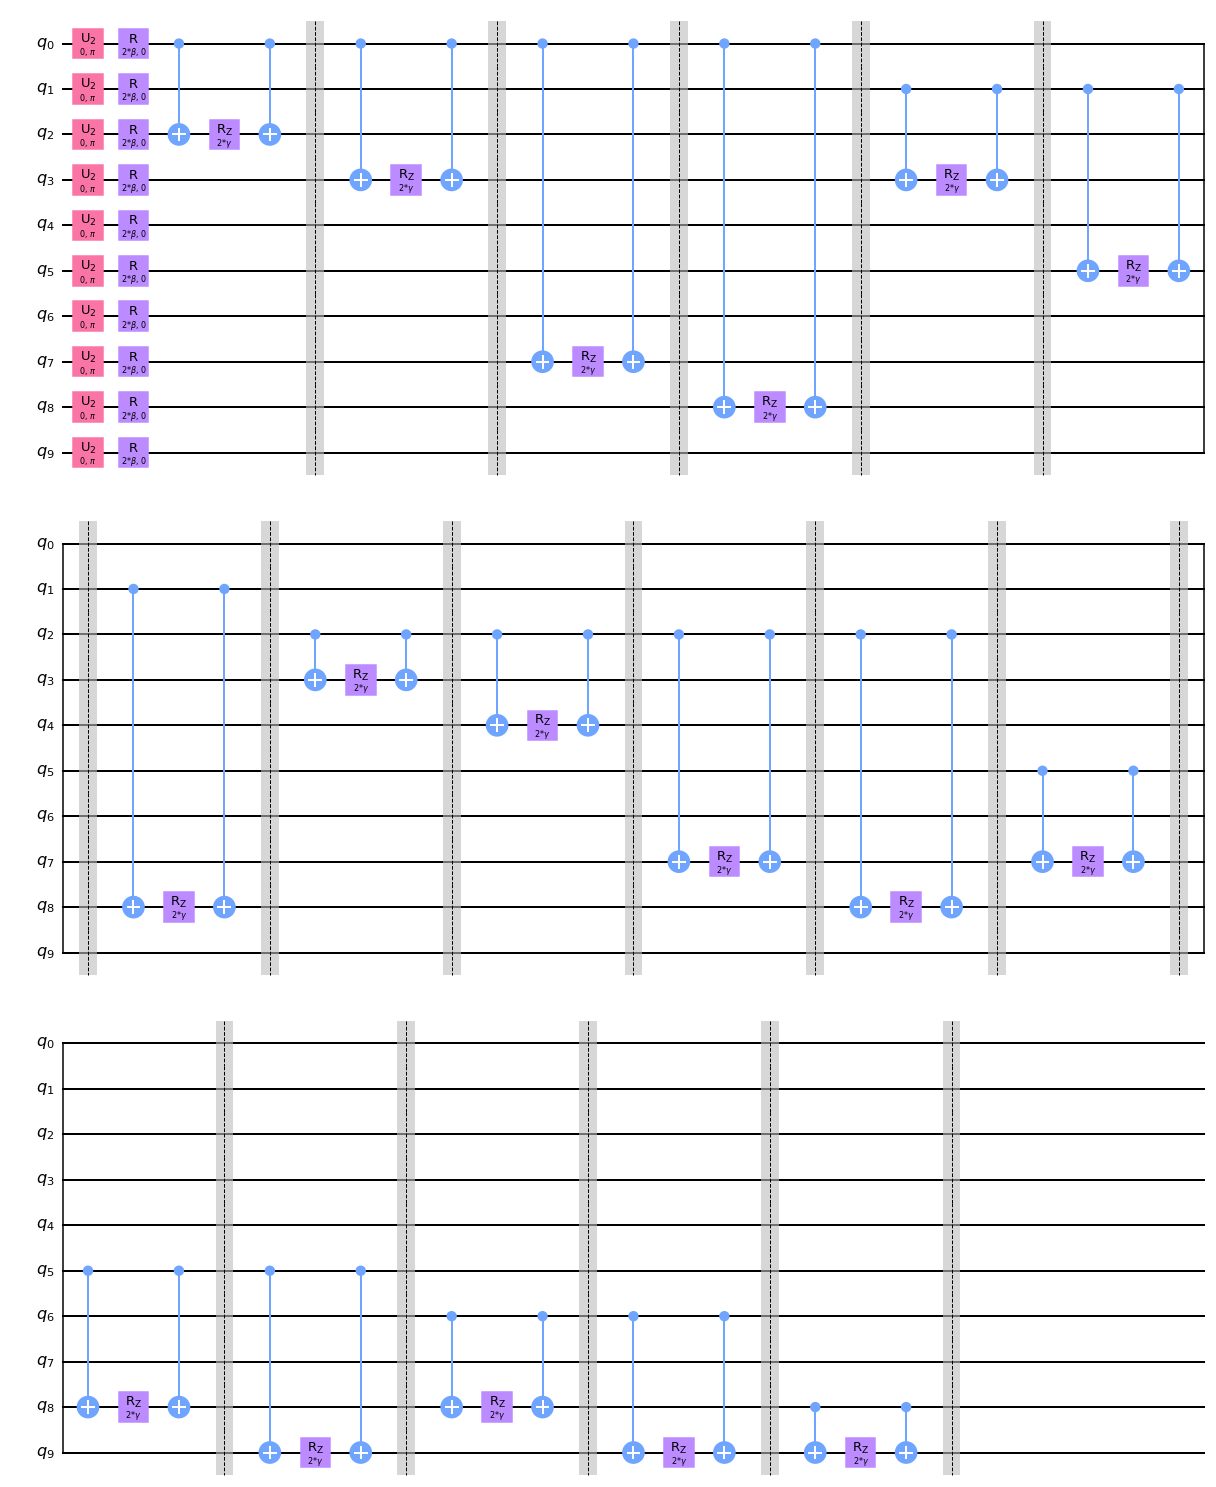

In [97]:
qc_qaoa = QuantumCircuit(nqubits)

qc_qaoa.append(qc_0, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_mix, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_p, [i for i in range(0, nqubits)])

qc_qaoa.decompose().decompose().draw(output='mpl')


Boilerplate for Maxcut

In [98]:
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
            
    return obj


def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring, G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(G, theta):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    
    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
        
    return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(G, p, shots=512):
    
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(G, theta)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()
        
        return compute_expectation(counts, G)
    
    return execute_circ


In [99]:
from scipy.optimize import minimize

expectation = get_expectation(G, p=1)

res = minimize(expectation, 
                      [1.0, 1.0], 
                      method='COBYLA')
res


     fun: -9.046875
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 31
  status: 1
 success: True
       x: array([1.12943346, 1.25398137])

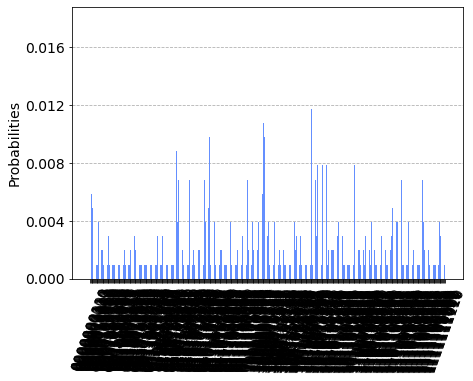

In [101]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_circ(G, res.x)

counts = backend.run(qc_res, seed_simulator=10).result().get_counts()

plot_histogram(counts, bar_labels=False)
#highest probability = correct graph assignment

In [110]:
# Interactive Visualization of the QAOA Outputs
import plotly.graph_objects as go
names = list(counts.keys())
values = list(counts.values())
# Specify the plots
bar_plots = [
    go.Bar(x=names, y=values, name='Data', marker=go.bar.Marker(color='#0343df')),
]
# Customise some display properties
layout = go.Layout(
    title=go.layout.Title(text="Frequency of different QAOA measurements", x=0.5),
    yaxis_title="Frequency",
    xaxis_tickmode="array",
    xaxis_tickvals=list(range(len(names))),
    xaxis_ticktext=tuple(names),
)
# Make the multi-bar plot
fig = go.Figure(data=bar_plots, layout=layout)
# Tell Plotly to render it
fig.show()


In [111]:
value = max(counts.values())
get_key = lambda d, value: [k for k, v in d.items() if v == value][0]

# Extract the bitstring
bitstring = get_key(counts, value)
bitstring = [int(x) for x in bitstring]

In [112]:
def plot_maxcut_on_network(G, x):
    """
    Plots the maximum cut of a graph on a network plot.
    """
    # Plot the maximum cut as node states, and the state of the nodes as node colors
    pos = nx.kamada_kawai_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=200)
    #Update the node colors based on the dense adjacency matrix
    node_colors = []
    for i in range(len(x)):
        if x[i,i] == 0:
                node_colors.append('red')
        else:
                node_colors.append('blue')
    # Kamada-Kawai layout seems to be better suited for dense graphs   
    nx.draw_networkx_nodes(G, pos, nodelist=range(len(x)), node_color=node_colors, node_size=200)    
    # Display the edge values (for toy problems)
    if len(G.nodes) < 10:
            edge_labels = dict([((u, v,), d['weight'])
                        for u, v, d in G.edges(data=True)])
            nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

    plt.show()


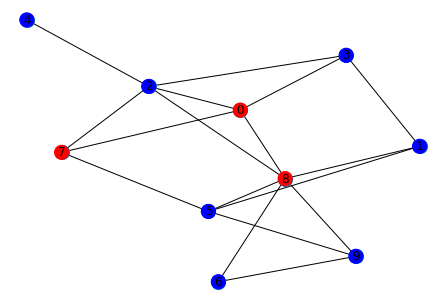

In [113]:
Q = np.diag(bitstring)
plot_maxcut_on_network(G, Q)